In [216]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numba import jit
import time
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis

In [217]:
dti_matrix = pd.read_csv('DTI_avg_matrix_2.csv')
#first_column = dti_matrix.iloc[:, 0]
#print(first_column)
first_column = dti_matrix['Precentral_L']
print(first_column)

0     0.000000
1     0.114779
2     0.633831
3     0.105549
4     0.001607
        ...   
87    0.000000
88    0.058762
89    0.002390
90    0.001271
91    0.000000
Name: Precentral_L, Length: 92, dtype: float64


In [218]:
n = 92
dti_c_matrix = dti_matrix.values

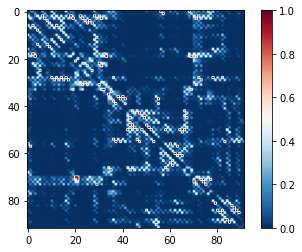

<Figure size 1080x1080 with 0 Axes>

In [219]:
import matplotlib.pyplot as plt
plt.imshow(dti_c_matrix, cmap = 'RdBu_r',vmin = 0,vmax =1)
plt.colorbar()
plt.figure(figsize=(15, 15))
plt.show()

In [220]:
def create_normal_distribution(mean, std, size):
    sample = np.random.normal(0, std, size**2)
    for i in range(size ** 2):
        if sample[i] > mean:
            sample[i] = (sample[i] - sample.mean()) / (sample.max() - sample.mean()) * (1 - mean) + mean
        if sample[i] < mean:
            sample[i] = (sample[i] - sample.min()) / (sample.mean() - sample.min()) * mean
    return sample
sample = create_normal_distribution(0.9, 1, 100)
print(sample.mean())

0.7719380805357324


In [221]:
def norm_matrix(mean, std, n):
    nlist = np.arange(0, n, 1)
    norm_matrix = np.zeros((n,n))
    count = 0
    sample = create_normal_distribution(mean, std, n)

    for i in nlist:
        for j in nlist:
            norm_matrix[i][j] = sample[count]
            count += 1
    return norm_matrix

In [222]:
a = norm_matrix(0.25 ,1, 10)
a
nlist = np.arange(0, 10, 1)
count = 0
for i in nlist:
    for j in nlist:
        count += a[i][j]
count = count / 100
count

0.3392010516415204

In [223]:
def create_nodes(n):
    values = []
    for i in range(n):
        value = random.choice([1, -1])
        values.append(value)
    return values

In [224]:
def conn_matrix(n):
    conn_matrix = np.random.uniform(0, 1, size=(n, n))
    conn_matrix = (conn_matrix + conn_matrix.T) / 2
    np.fill_diagonal(conn_matrix, 0)
    max_conn = np.max(conn_matrix)
    conn_matrix = conn_matrix / max_conn
    return conn_matrix

In [225]:
def energy_diff(list0, c_matrix, n):
    pos = random.randint(0, n - 1)
    nodes_without_pos = [x for x in range(n) if x != pos]
    delta_E = 0
    for i in nodes_without_pos:
        add = 2 * list0[pos] * list0[i] * c_matrix[pos, i]
        delta_E += add
    return delta_E, pos

In [226]:
def metropolis(list0, n_iterations, T, c_matrix, probability, n):
    node_list = list0
    magnetisation_list = []
    for i in range(n_iterations):
        diff = energy_diff(node_list, c_matrix, n)
        #print(diff)
        if diff[0] <= 0:
            if node_list[diff[1]] == 1: #flip at pos
                node_list[diff[1]] = -1
            else:
                node_list[diff[1]] = 1
        else:
            if random.random() < np.exp(-diff[0]/T):
                if node_list[diff[1]] == 1:
                    node_list[diff[1]] = -1
                else:
                    node_list[diff[1]] = 1

        magnetisation = abs(np.mean(node_list))
        magnetisation_list.append(magnetisation)
    magnetisation_list = magnetisation_list[500:] #disregard first 500
    avg_magnetisation = np.mean(magnetisation_list) 
    
    mean_of_squared = np.mean([M**2 for M in magnetisation_list])
    susceptibility = (mean_of_squared - avg_magnetisation**2)/T

    return node_list, avg_magnetisation, susceptibility

In [227]:
def multi_metropolis(n_simulations, n_iterations, T, probability, mean, std, n):
    list_avg_magnetisation = []
    list_sus = []
    c_matrix = norm_matrix(mean, std, n) # remember to change if not using connectome
    
    for i in range(n_simulations):
        nodes = create_nodes(n)
        c_matrix = norm_matrix(mean, std, n)
        node_list, avg_magnetisation, susceptibility = metropolis(nodes, n_iterations, T, c_matrix, probability, n) 
        list_avg_magnetisation.append(avg_magnetisation)
        list_sus.append(susceptibility)

    mean_magnet = np.mean(list_avg_magnetisation)
    std_magnet = np.std(list_avg_magnetisation)
    
    mean_sus = np.mean(list_sus)
    std_sus = np.std(list_sus)
    
    return mean_magnet, std_magnet, mean_sus, std_sus

In [244]:
temperatures = np.linspace(0.01, 20, 50)
probability_list = [0.5]
n_simulations = 20
n_iterations = 20000

def magnetisation_plotting(n_simulations, n_iterations, mean, std, n):
    means_mag = []
    stds_mag = []
    means_sus = []
    stds_sus = []
    for probability in probability_list:
        for T in temperatures:
            mean_mag, std_mag, mean_sus, std_sus = multi_metropolis(n_simulations, n_iterations, T, probability, mean, std, n)
            means_mag.append(mean_mag)
            stds_mag.append(std_mag)
            means_sus.append(mean_sus)
            stds_sus.append(std_sus)
        
        max_sus = max(means_sus)
        max_temperature = means_sus.index(max(means_sus))
        
        lower_bound = np.subtract(means_mag, stds_mag)
        upper_bound = np.add(means_mag, stds_mag)
        plt.plot(temperatures, means_mag)
        plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)
        plt.xlabel('T')
        plt.ylabel('M')
        plt.grid()
        plt.show()

        lower_bound = np.subtract(means_sus, stds_sus)
        upper_bound = np.add(means_sus, stds_sus)
        plt.plot(temperatures, means_sus)
        plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)
        plt.xlabel('T')
        plt.ylabel('Susceptibility')
        plt.title("Susceptibility at %f" %mean)
        plt.grid()
        plt.show()
        
        means_mag = []
        stds_mag =[]
        means_sus =[]
        stds_sus = []
        return max_sus, max_temperature

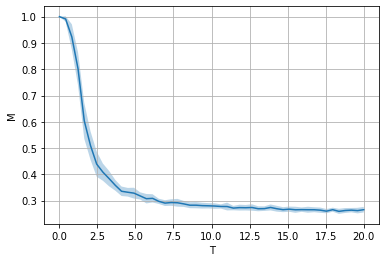

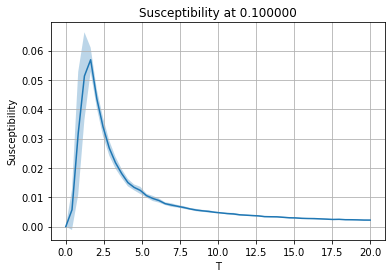

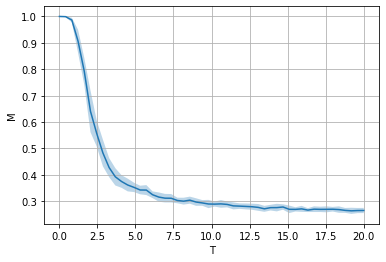

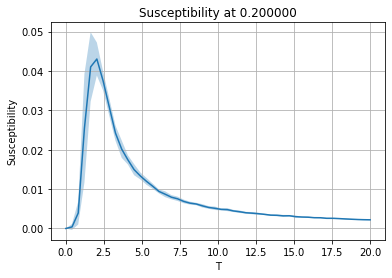

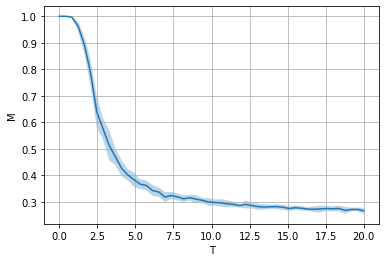

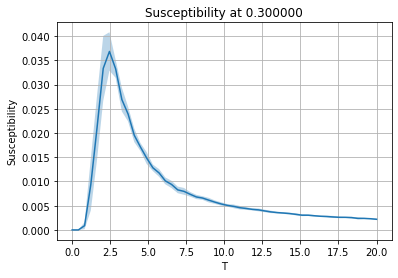

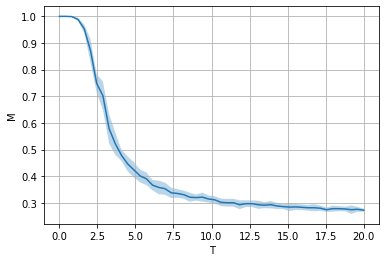

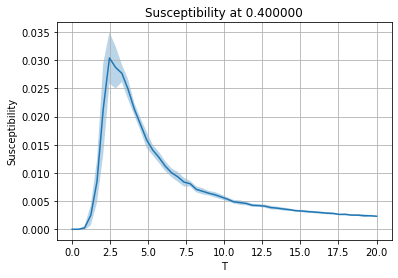

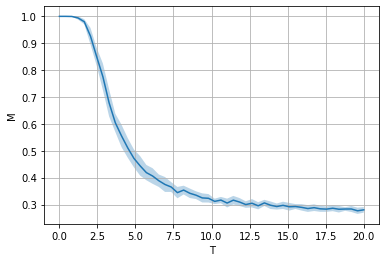

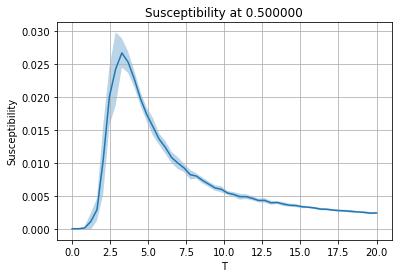

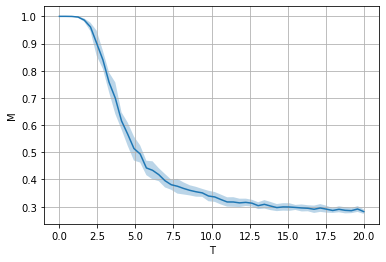

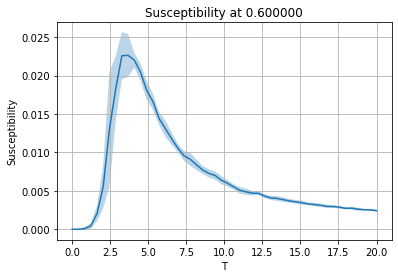

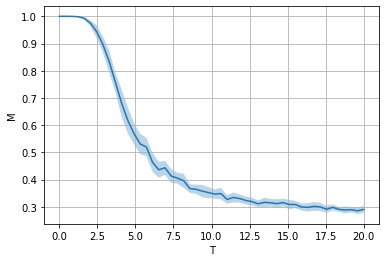

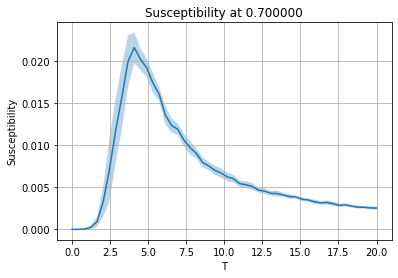

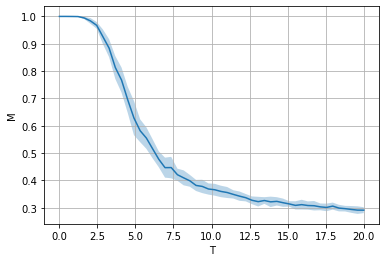

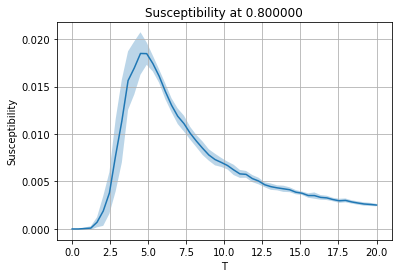

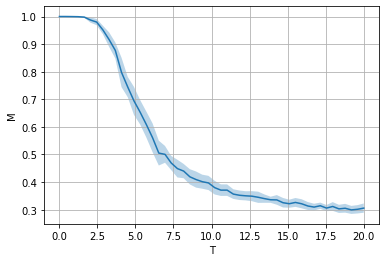

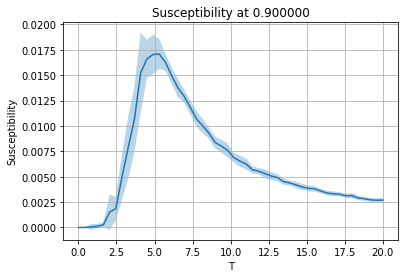

308.6140823364258


In [245]:
start_time = time.time()
adjust_mean_list = (0.1,0.2,0.3,0.4,0.5,0.6, 0.7,0.8,0.9)
max_sus_list = []
critical_temerature_list = []
for mean in adjust_mean_list:
    max_sus, critical_temperature= magnetisation_plotting(20, 2500, mean , 1, 10)
    max_sus_list.append(max_sus)
    critical_temerature_list.append(critical_temperature)
end_time = time.time()
print(end_time - start_time)

In [246]:
max_sus_list

[0.05686426672467376,
 0.04303571234070093,
 0.03682495498629912,
 0.03042853860333807,
 0.026667352231781082,
 0.022632497278270526,
 0.02155596414491743,
 0.01848547701243308,
 0.017083987386695355]

Text(0.5, 1.0, 'maximum susceptibility - adjusted mean')

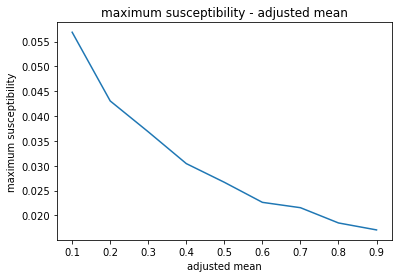

In [255]:
plt.plot(adjust_mean_list, max_sus_list)
plt.xlabel('adjusted mean')
plt.ylabel('maximum susceptibility')
plt.title('maximum susceptibility - adjusted mean')

In [254]:
critical_temperature_list1 = []
for sequence in critical_temerature_list:
    temperature = sequence * 0.4
    critical_temperature_list1.append(temperature)

Text(0.5, 1.0, 'critical temeprature - adjusted mean')

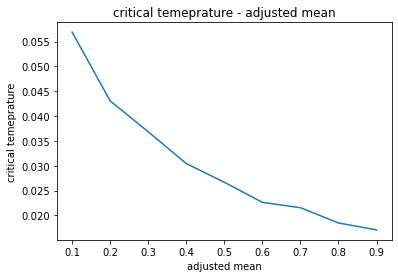

In [256]:
plt.plot(adjust_mean_list, max_sus_list)
plt.xlabel('adjusted mean')
plt.ylabel('critical temeprature')
plt.title("critical temeprature - adjusted mean")